## 新能源电动汽车动力电池充电能量预测（四）——缺失数据填充

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from datetime import date, datetime
from package import utils
from scipy import stats

### 数据导入

In [2]:
# 导入经过异常检测后的数据集合
dataset = pd.read_csv('./energy_predict_data/data_prehandle/3_outlier_detection/predict_data_e_train.csv')
# 数据字段
header = dataset.columns.values.tolist()
# 数据集大小
count = np.max(dataset['vehicle_id'])
# 数据描述
pd.set_option('precision', 2)
dataset.describe()

,vehicle_id,charge_start_time,charge_end_time,charge_duration,mileage,delta_mileage,charge_start_soc,charge_end_soc,charge_delta_soc,charge_start_U,charge_end_U,charge_start_I,charge_end_I,charge_max_temp,charge_min_temp,charge_delta_temp,charge_energy
count,5990.00,5.99e+03,5.99e+03,5990.00,5990.00,5972.00,5913.00,5790.00,5788.00,5990.00,5980.00,5990.00,5980.00,5990.00,5990.00,5990.00,5978.00
mean,11.37,2.02e+13,2.02e+13,7178.32,103588.11,102.13,35.57,76.31,40.73,405.94,436.13,-43.74,-22.32,27.19,15.15,12.04,25.94
std,6.45,4.00e+09,4.00e+09,8366.48,30819.13,64.93,19.47,27.23,22.59,91.53,87.88,48.22,35.36,10.62,11.57,9.95,21.26
min,1.00,2.02e+13,2.02e+13,600.00,45631.70,0.00,0.00,0.00,0.00,252.30,0.00,-202.00,-400.00,-2.00,-7.00,0.00,0.22
25%,5.00,2.02e+13,2.02e+13,2168.25,78704.15,63.00,20.40,50.00,22.00,340.40,374.60,-59.80,-20.40,18.00,5.00,6.00,12.61
50%,11.00,2.02e+13,2.02e+13,3861.00,97276.05,93.15,34.00,88.00,38.00,361.50,391.60,-24.00,-9.30,30.00,14.00,9.00,19.59
75%,17.00,2.02e+13,2.02e+13,6429.00,122780.75,133.00,47.00,100.00,61.05,533.70,551.70,-9.00,-5.00,35.00,25.00,12.00,29.58
max,21.00,2.02e+13,2.02e+13,59960.00,182536.00,490.00,96.00,100.00,99.00,574.60,604.70,-0.10,8.00,52.00,46.00,51.00,103.72


#### 数据缺失情况

In [3]:
dataset.isnull().sum()

vehicle_id             0
charge_start_time      0
charge_end_time        0
charge_duration        0
mileage                0
delta_mileage         18
charge_start_soc      77
charge_end_soc       200
charge_delta_soc     202
charge_start_U         0
charge_end_U          10
charge_start_I         0
charge_end_I          10
charge_max_temp        0
charge_min_temp        0
charge_delta_temp      0
charge_energy         12
dtype: int64

#### 每辆车上含有缺失值的数量分布

/Users/Jeremy/miniconda3/envs/test/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


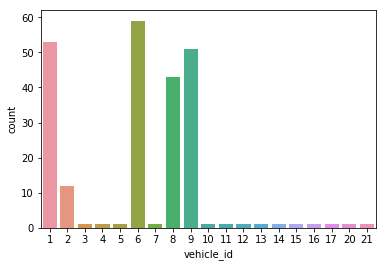

In [4]:
# 缺失数据集
dataset_with_null = dataset[dataset.T.isnull().any()]
null_index_list = dataset_with_null.index.tolist()
for i in range(len(null_index_list)):
    null_index_list[i] = null_index_list[i] - i
sns.countplot(x='vehicle_id', data=dataset_with_null)

>观察1：整体来说，缺失情况不是很严重；只有delta_mileage、charge_start_soc、charge_end_soc、charge_delta_soc、charge_energy这些字段存在缺失。

>观察2：相对来说，第6辆车缺失较多。

>方法：采用聚类思想进行数据填充：选择参与聚类的字段是很重要的，根据第2步特征工程的结论，我们选择charge_duration、delta_mileage、charge_start_soc、charge_delta_soc、charge_start_U、charge_min_temp这些特征信息进行聚类。然后，对含有缺失值记录按照欧式距离寻找距其最近的类，然后用该类中心属性值对缺失值进行填充。

### 数据填充。

#### 获取完美数据集

In [5]:
# 完美数据集
dataset_without_null = dataset[~dataset.T.isnull().any()]

/Users/Jeremy/miniconda3/envs/test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


((array([-3.67190921, -3.43876825, -3.31038175, ...,  3.31038175,
          3.43876825,  3.67190921]),
  array([   0.217,    0.413,    0.413, ...,  102.7  ,  103.674,  103.722])),
 (19.576391466200469, 26.242362278568947, 0.90849802418473746))

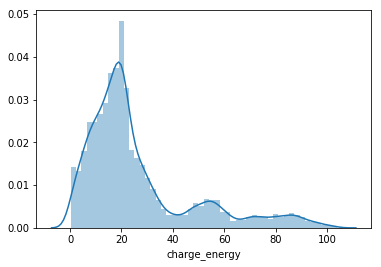

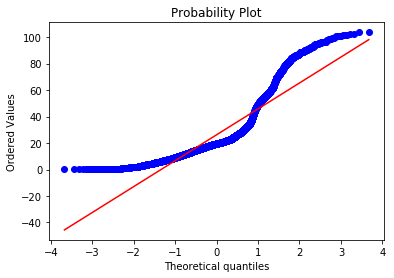

In [6]:
from scipy import stats
fig = plt.figure()
sns.distplot(dataset_without_null['charge_energy']);
fig = plt.figure()
stats.probplot(dataset_without_null['charge_energy'], plot=plt)

#### 使用KMeans对用完美数据集进行聚类

<bound method KMeans.score of KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=3, tol=0.0001, verbose=0)>


/Users/Jeremy/miniconda3/envs/test/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


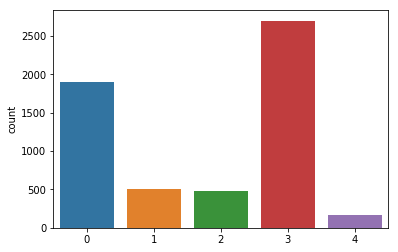

In [7]:
from sklearn.cluster import KMeans
#聚类和填充需要操作的列名
compute_header = ['charge_duration', 'delta_mileage', 'charge_start_soc', 'charge_delta_soc', 'charge_min_temp', 'charge_energy']
cluster_source = dataset_without_null[compute_header]
kmeans = KMeans(n_clusters=5, random_state=3).fit(cluster_source)
cluster = kmeans.cluster_centers_
labels = kmeans.labels_
print(kmeans.score)
sns.countplot(labels)

#### 利用聚类结果进行数据填充

In [8]:
#转化为array
dataset_with_null_values = dataset_with_null[compute_header].values
for i in range(len(dataset_with_null_values)):
    maxD = float('inf')
    maxV = []
    data = dataset_with_null_values[i]
    for center in cluster:
        dis = utils.distance(center, data)
        if dis < maxD:
            maxD = dis
            maxV = center
    dataset_with_null_values[i] = utils.filling(maxV,data)
    

In [9]:
#填充结果覆盖到不完美数据集
dataset_with_null_filled = pd.DataFrame(dataset_with_null_values,columns=compute_header)
dataset_with_null_filled.describe()

,charge_duration,delta_mileage,charge_start_soc,charge_delta_soc,charge_min_temp,charge_energy
count,232.00,232.00,232.00,232.00,232.00,232.00
mean,12019.18,98.98,34.08,48.25,7.94,18.38
std,10578.16,45.02,10.04,14.05,6.63,8.70
min,690.00,0.10,1.00,5.60,-2.00,1.99
25%,3852.50,80.65,29.20,45.44,3.00,14.51
50%,5275.00,92.75,33.60,45.44,7.00,19.58
75%,24200.75,108.55,38.84,60.52,10.00,21.23
max,35652.00,418.00,94.00,93.00,35.00,80.50


In [10]:
dataset_with_null_filled['charge_end_soc'] = dataset_with_null_filled['charge_start_soc'] + dataset_with_null_filled['charge_delta_soc']
temp = pd.DataFrame()
for col in compute_header:
    temp[col] = dataset_with_null_filled[col]

for col in list(set(header).difference(set(compute_header))):
    temp[col] = dataset_with_null[col].tolist()

temp['charge_end_soc'] = dataset_with_null_filled['charge_end_soc'].tolist()
temp = temp[header]

# 填充后的完整数据集合
dataset_whole = pd.DataFrame(
    np.insert(dataset_without_null.values, null_index_list, temp.values, axis=0), 
    columns=dataset_without_null.columns)

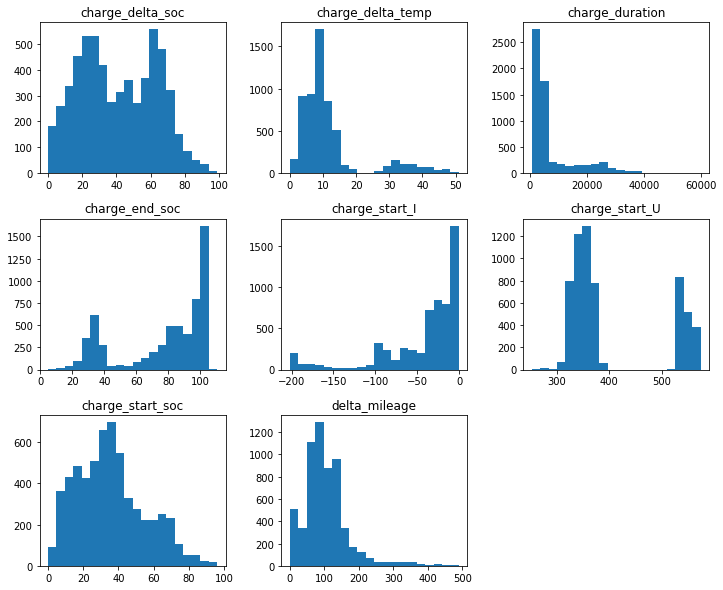

In [11]:
features = ['charge_duration', 
            'delta_mileage',
            'charge_start_soc', 
            'charge_delta_soc', 
            'charge_end_soc',
            'charge_start_U',
            'charge_start_I',
            'charge_delta_temp']
dataset_whole[features].hist(bins=20,figsize=(12,10),grid=False);

### 保存完美数据、缺失数据及填充后的完整数据集

In [12]:
dataset_with_null.to_csv("./energy_predict_data/data_prehandle/4_fill_null/not_perfect/unfilled/predict_data_e_train.csv", index=False)
dataset_without_null.to_csv("./energy_predict_data/data_prehandle/4_fill_null/perfect/predict_data_e_train.csv", index=False)
temp.to_csv("./energy_predict_data/data_prehandle/4_fill_null/not_perfect/filled_by_kmeans/predict_data_e_train.csv", index=False)
dataset_whole.to_csv("./energy_predict_data/data_prehandle/4_fill_null/whole/filled_by_kmeans/predict_data_e_train.csv", index=False)

for i in range(1, count+1):
    data_with_null = dataset_with_null[(dataset_with_null['vehicle_id']==i)]
    data_with_null.to_csv("./energy_predict_data/data_prehandle/4_fill_null/not_perfect/unfilled/predict_data_e_train_%d.csv" % i, index=False)
    
    data_without_null = dataset_without_null[(dataset_without_null['vehicle_id']==i)]
    data_without_null.to_csv("./energy_predict_data/data_prehandle/4_fill_null/perfect/predict_data_e_train_%d.csv" % i, index=False)
    
    data_fill_null = temp[(temp['vehicle_id']==i)]
    data_fill_null.to_csv("./energy_predict_data/data_prehandle/4_fill_null/not_perfect/filled_by_kmeans/predict_data_e_train_%d.csv" % i, index=False)
    
    data_whole = dataset_whole[(dataset_whole['vehicle_id']==i)]
    data_whole.to_csv("./energy_predict_data/data_prehandle/4_fill_null/whole/filled_by_kmeans/predict_data_e_train_%d.csv" % i, index=False)
    